In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import tensorflow.keras as keras

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn import svm

In [2]:
# Import training data
train_df = pd.read_csv("C:/Users/peiha/Documents/GitHub/ApplyAIGroupProject/cleaned_train.csv")
train_df.head(2)

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,6,0,Multifamily_Uncategorized,76772.0,1931.0,59.0,25.0,11,34.451613,59,...,0,0,87.859290,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6,0,Multifamily_Uncategorized,84757.0,2007.0,46.0,42.7,11,34.451613,59,...,0,0,63.924863,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
# Import test data
test_df = pd.read_csv("C:/Users/peiha/Documents/GitHub/ApplyAIGroupProject/cleaned_test.csv")
test_df.head(2)

,Year_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,...,days_above_100F,days_above_110F,site_eui,x0_State_1,x0_State_10,x0_State_11,x0_State_2,x0_State_4,x0_State_6,x0_State_8
0,3,1,Office_Uncategorized,184405.0,1917.0,72.0,15.2,11,35.080645,61,...,0,0,56.637582,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,4,1,Office_Uncategorized,736974.0,1960.0,55.0,42.7,4,28.596774,58,...,0,0,106.618289,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [4]:
# Calculate correlation matrix and plot

numeric_features = train_df.select_dtypes(exclude=['object']).columns.tolist()
numeric_features.remove('site_eui')
cor_matrix = train_df[numeric_features + ['site_eui']].corr()
#cor_matrix

In [5]:
# Find features that have correlation > 0.2  with 'site_eui'
features_with_higher_cor_to_target = cor_matrix['site_eui'][cor_matrix['site_eui'].abs() > 0.2].index.tolist()
features_with_higher_cor_to_target.remove('site_eui')
print("Features selected ", features_with_higher_cor_to_target)

Features selected  ['energy_star_rating', 'january_min_temp', 'january_avg_temp', 'february_min_temp', 'february_avg_temp', 'march_min_temp', 'march_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_min_temp', 'july_avg_temp', 'august_min_temp', 'august_avg_temp', 'september_min_temp', 'september_avg_temp', 'september_max_temp', 'cooling_degree_days', 'heating_degree_days', 'snowfall_inches', 'snowdepth_inches', 'days_below_30F', 'days_below_20F', 'days_above_80F', 'x0_State_11', 'x0_State_6']


In [6]:
#Plot these high-correlated features using heatmap
high_cor_matrix = train_df[features_with_higher_cor_to_target + ['site_eui']].corr()
#plt.figure(figsize = (20,20))
#sns.heatmap(high_cor_matrix, annot = True)

In [7]:
# Plot the absolute correlation with 'site_eui' using histogram

# Extract features that correlated with 'site_eui'
high_cor_eui = high_cor_matrix.filter(['site_eui'],axis=1) # axis = 1 in a column order; axis = 0 in a row order
# Get a column of absolute correlation
high_cor_eui_abs = high_cor_eui#.abs()

# Change the name 'site_eui' into 'Abs_Corr'
high_cor_eui_abs.rename({'site_eui':'Abs_Corr'}, axis='columns',inplace=True)

# Give the first column a name 'Features'
high_cor_eui_abs.index.name = 'Features'
high_cor_eui_abs.reset_index(inplace=True)

#high_cor_eui_abs

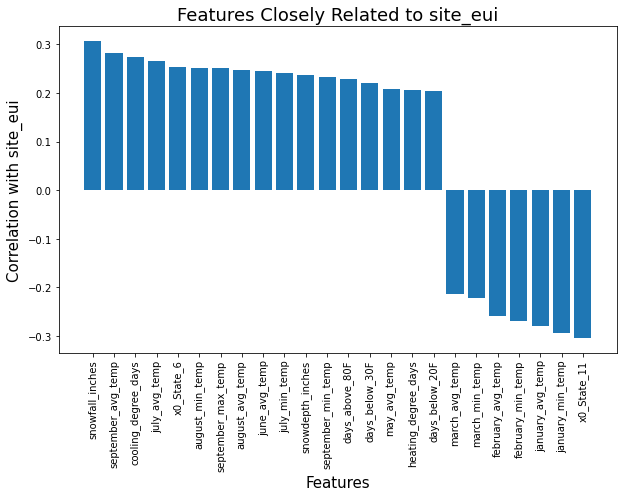

In [8]:
# Drop the site_eui's self-correlation and energy_star_rating
corr_without_eui = high_cor_eui_abs[high_cor_eui_abs['Features'].str.contains('site_eui|energy_star_rating')==False]

# Sort our dataframe in a descending order
df_sorted= corr_without_eui.sort_values('Abs_Corr',ascending=False)

plt.figure(figsize=(10,6))
# make bar plot with matplotlib
plt.xlabel('Features', size=15)
plt.ylabel('Correlation with site_eui', size=15)
plt.title('Features Closely Related to site_eui', size=18)

# Vertical aligned
plt.xticks(rotation='vertical')
plt.bar('Features','Abs_Corr',data=df_sorted)

# Save plot
plt.savefig('corr_eui_bar.png', facecolor='w')

In [9]:
# Set training data's target and body
y_train = train_df['site_eui']
X_train = train_df.drop(columns = ['site_eui','facility_type'])
# Same for the test data
y_test = test_df['site_eui']
X_test = test_df.drop(columns = ['site_eui','facility_type'])

In [10]:
# Model 1 - Linear Regression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make a prediction and get the MSE
y_pred_lr = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print("MSE for Linear Regression Model:", mse_lr)

MSE for Linear Regression Model: 731.4467046443224


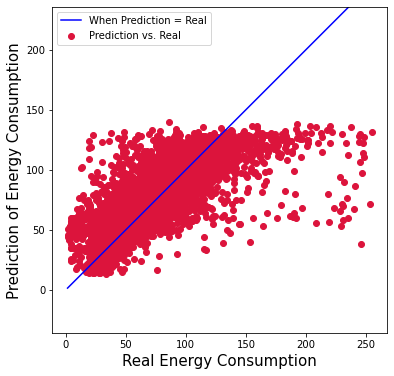

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lr, c='crimson', label="Prediction vs. Real")

p1 = max(max(y_pred_lr), max(y_test))
p2 = min(min(y_pred_lr), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label="When Prediction = Real")
plt.xlabel('Real Energy Consumption', fontsize=15)
plt.ylabel('Prediction of Energy Consumption', fontsize=15)
plt.axis('equal')
plt.ylim(0, 200)

plt.legend(loc="upper left")

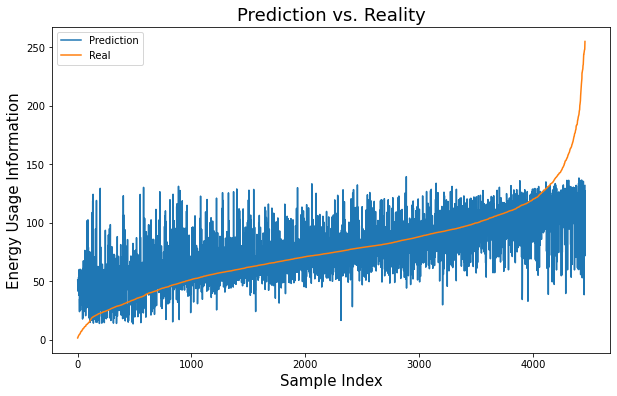

In [12]:
# Draw the Prediction and Real value in an ascending order

df_pred_real=y_test.to_frame()
df_pred_real['Pred'] = y_pred_lr.tolist()
df_pred_real.rename({'site_eui':'Real'}, axis='columns',inplace=True)

# Sort our dataframe in an ascending order
df_pred_real= df_pred_real.sort_values('Real',ascending=True)
df_pred_real.reset_index(inplace=True)

# Set labels and title, and reset the index
plt.figure(figsize=(10,6))
plt.xlabel('Sample Index', size=15)
plt.ylabel('Energy Usage Information', size=15)
plt.title('Prediction vs. Reality', size=18)

# Plot prediction y_pred
plt.plot(df_pred_real.index, df_pred_real['Pred'],label='Prediction')
plt.plot(df_pred_real.index, df_pred_real['Real'],label='Real')

plt.legend()

# Save plot
plt.savefig('Pred_vs_Real.png', facecolor='w')

In [13]:
# Model 2 - Support Vector Machine
model_svm = svm.SVR(cache_size=5000,kernel='poly')
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)
model_svm.fit(X_train, y_train)

# Make a prediction and get the MSE
y_pred_svm = model_svm.predict(X_test)
mse_svm = mean_squared_error(y_test, y_pred_svm)
print("MSE for Support Vector Machine Model:", mse_svm)

MSE for Support Vector Machine Model: 783.5786150059574


In [14]:
# Model 3 - Long-Short Term Memory (LSTM)

# Put data into one scale
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
#print(X_test.shape, y_train.shape, X_test.shape, y_test.shape)

# build network topology
model_lstm = keras.Sequential()
model_lstm.add(keras.layers.LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(keras.layers.Dense(1))
model_lstm.compile(loss='mse', optimizer='adam')
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                22800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 22,851
Trainable params: 22,851
Non-trainable params: 0
_________________________________________________________________


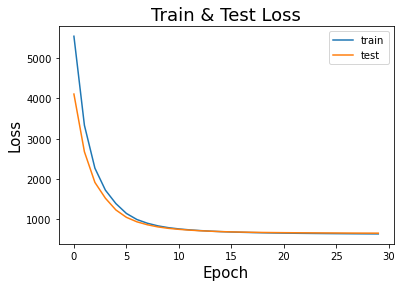

In [15]:
# fit network
history = model_lstm.fit(X_train, y_train, epochs=30, batch_size=72, validation_data=(X_test, y_test), verbose=0, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

plt.xlabel('Epoch', size=15)
plt.ylabel('Loss', size=15)
plt.title('Train & Test Loss', size=18)

plt.legend()

plt.savefig('Training_and_Test_Loss.png', facecolor='w')

In [16]:
# make a prediction
y_pred_lstm = model_lstm.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print("MSE for LSTM Model:", mse_lstm)

MSE for LSTM Model: 661.4882295805479


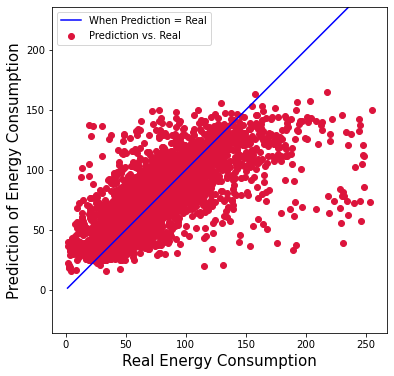

In [17]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_lstm, c='crimson', label="Prediction vs. Real")

p1 = max(max(y_pred_lstm), max(y_test))
p2 = min(min(y_pred_lstm), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-', label="When Prediction = Real")
plt.xlabel('Real Energy Consumption', fontsize=15)
plt.ylabel('Prediction of Energy Consumption', fontsize=15)
plt.axis('equal')
plt.ylim(0, 200)

plt.legend(loc="upper left")

In [18]:
print("MSE for Linear Regression Model:", mse_lr)
print("MSE for Support Vector Machine Model:", mse_svm)
print("MSE for LSTM Model after 30 iterations:", mse_lstm)

MSE for Linear Regression Model: 731.4467046443224
MSE for Support Vector Machine Model: 783.5786150059574
MSE for LSTM Model after 30 iterations: 661.4882295805479
